hx =  0.031415926535897934
hy =  0.031415926535897934
tau =  0.05


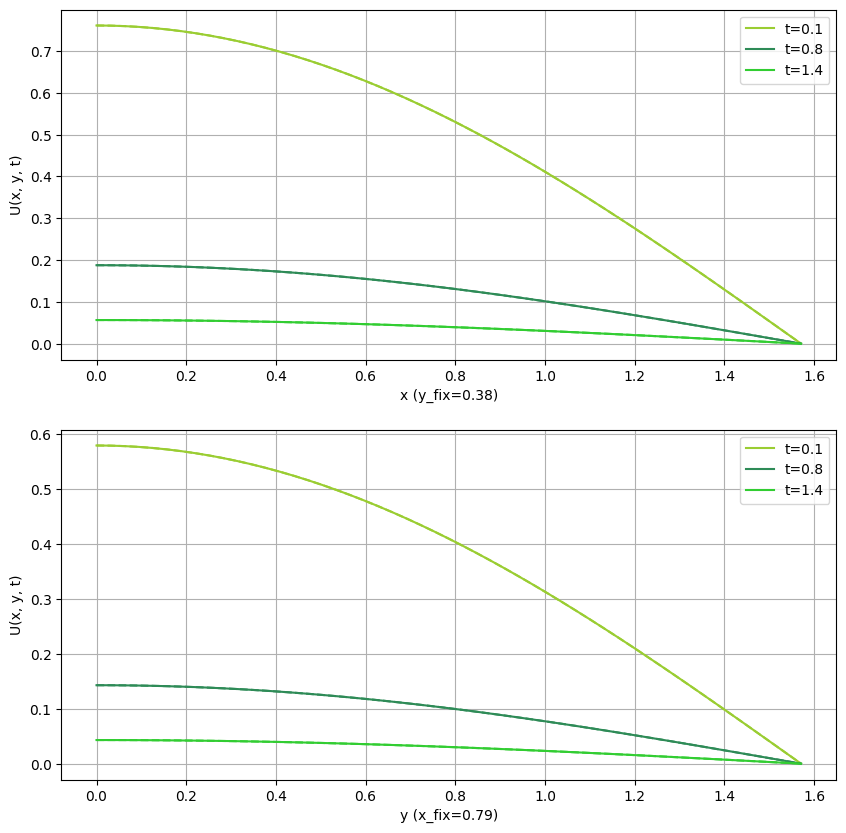

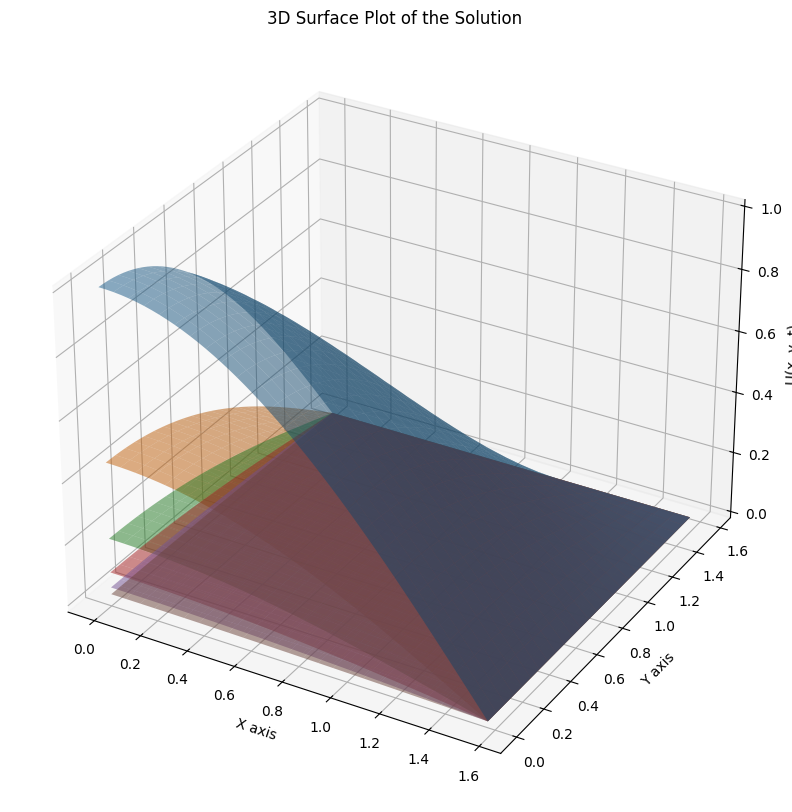

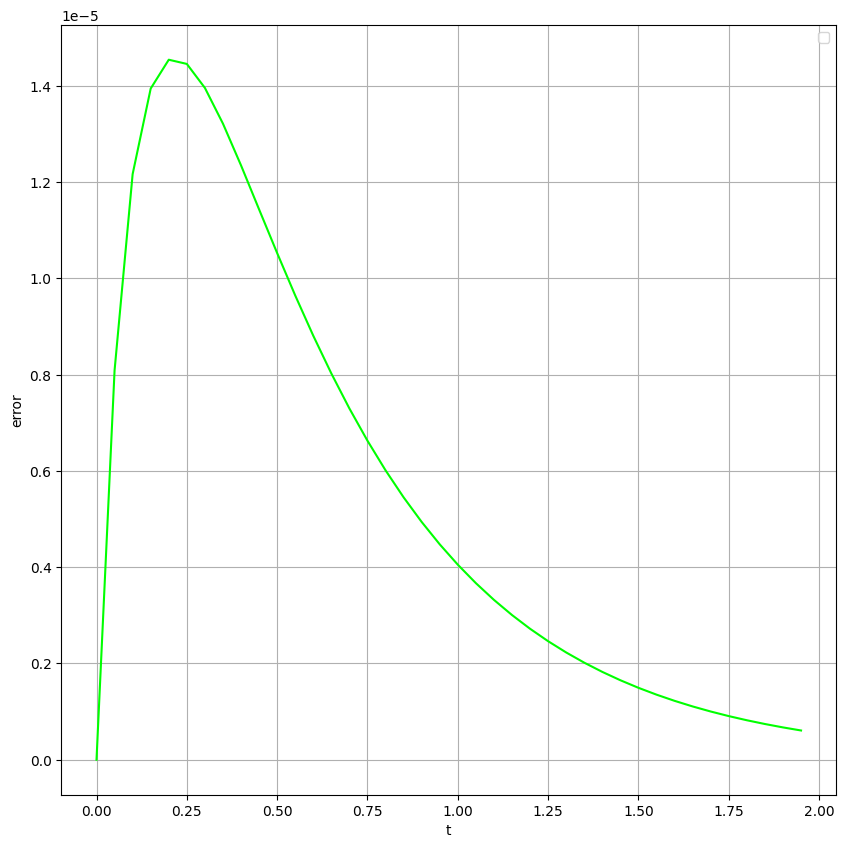

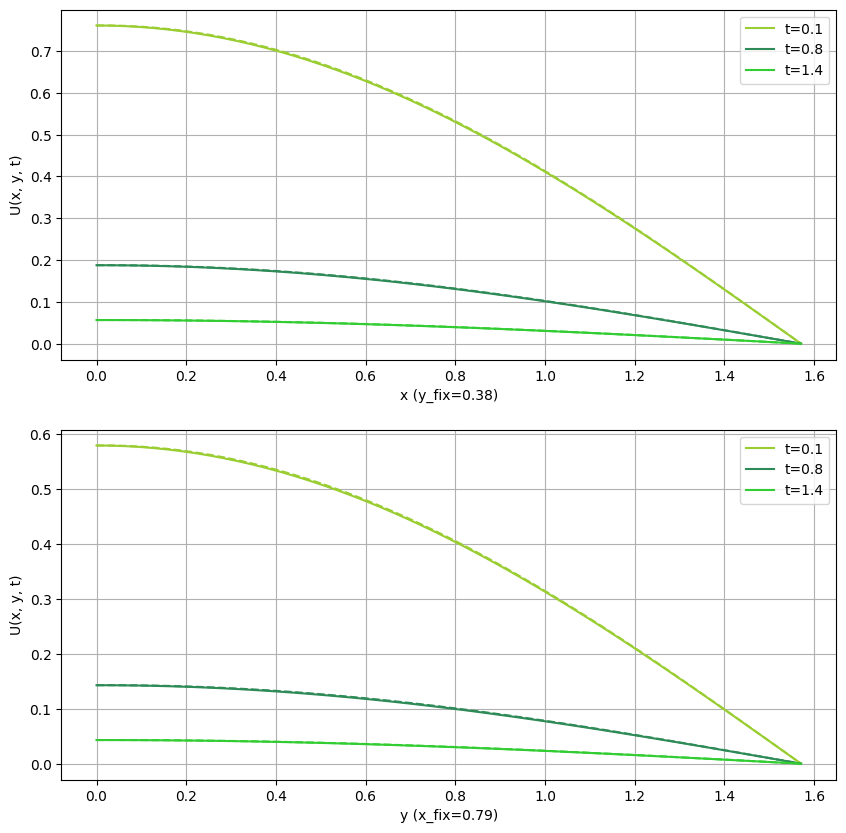

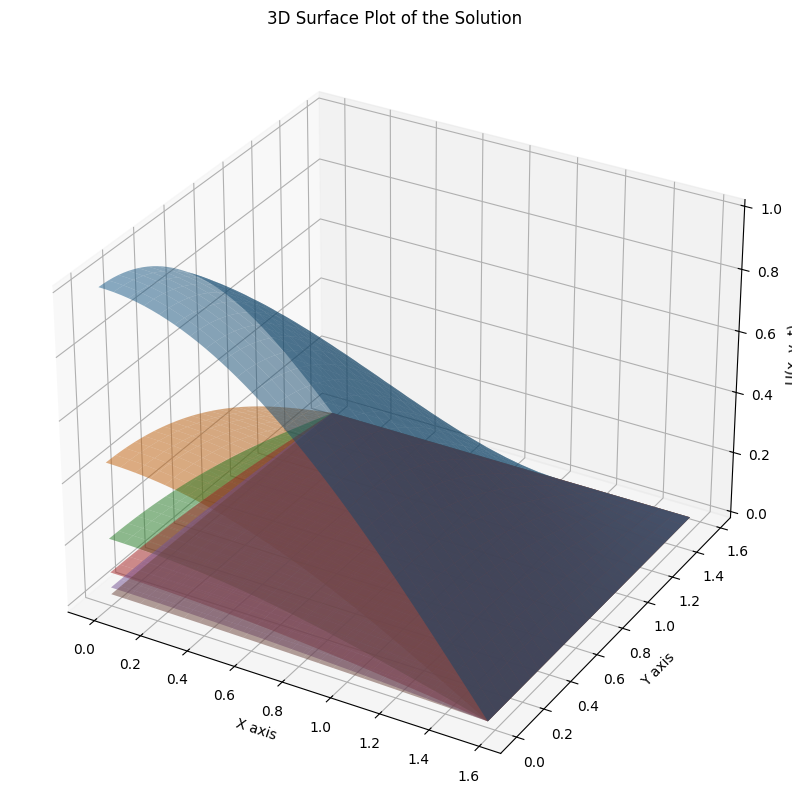

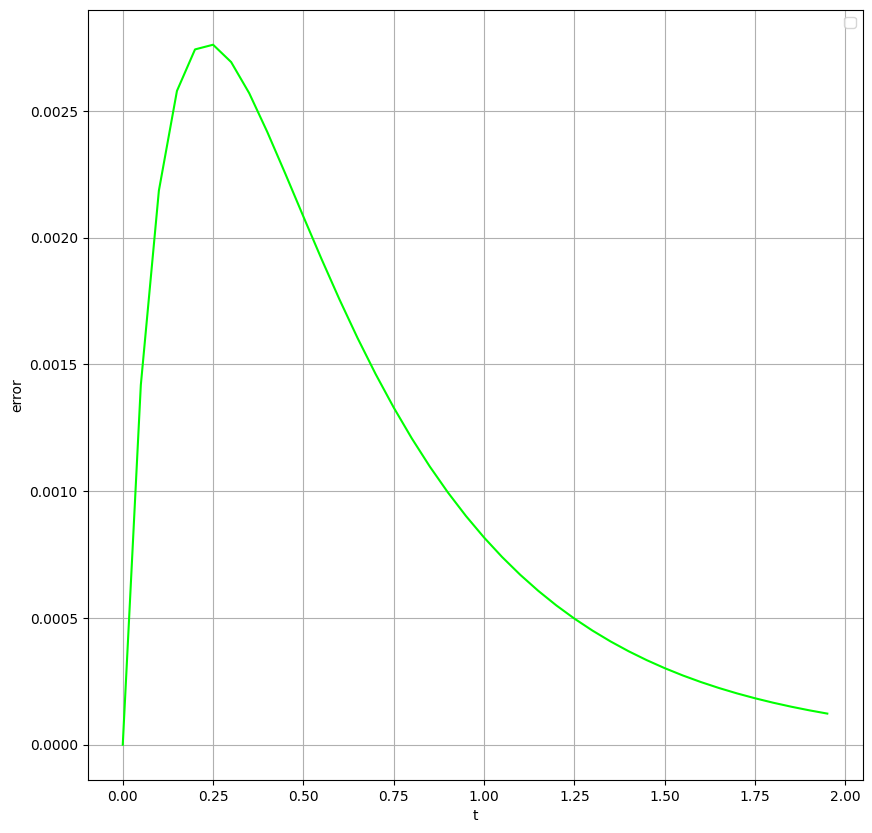

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D  # Импортируем 3D инструменты

plt.rcParams['figure.figsize'] = [10, 10]

# Определение начальных и краевых условий
mu1 = 1
mu2 = 1
a = 1

def phi1(x, t):
    return np.cos(mu1*x)*np.exp(-(mu1*mu1 + mu2*mu2)*a*t)

def phi2(x, t):
    return 0

def phi3(y, t):
    return np.cos(mu2*y)*np.exp(-(mu1*mu1 + mu2*mu2)*a*t)

def phi4(y, t):
    return 0

def psi(x, y):
    return np.cos(mu1*x)*np.cos(mu2*y)

# Определение точного решения
def U(x, y, t):
    return np.cos(mu1*x)*np.cos(mu2*y)*np.exp(-(mu1*mu1 + mu2*mu2)*a*t)

# Функция для вычисления ошибок
def norm(v1, v2):
    return np.amax(np.abs(v1 - v2))

def Error(Nx, Ny, Nt, hx, hy, tau, U, mesh):
    errors = np.zeros(Nt + 1)
    for t in range(Nt + 1):
        u_correct = np.zeros((Nx + 1, Ny + 1))
        for x in range(Nx + 1):
            for y in range(Ny + 1):
                u_correct[x][y] = U(x * hx, y * hy, t * tau)
        u_calculated = mesh[t]
        errors[t] = norm(u_correct, u_calculated)
    return errors

# Функция для построения графиков решения
def show_solution(Nx, Ny, Nt, hx, hy, tau, U, mesh):
    x_array = np.array([i * hx for i in range(Nx + 1)])
    y_array = np.array([j * hy for j in range(Ny + 1)])
    fig, ax = plt.subplots(2)
    t = [int(Nt * 0.05), int(Nt * 0.4), int(Nt * 0.7)]
    x_fix = int(Nx / 2)
    y_fix = int(Ny / 4)
    colors = ['yellowgreen', 'seagreen', 'limegreen']

    for i in range(len(t)):
        u_correct = np.zeros(Nx + 1)
        for x in range(Nx + 1):
            u_correct[x] = U(x * hx, y_fix * hy, t[i] * tau)
        u_calculated = mesh[t[i]][:][y_fix]

        ax[0].plot(y_array, u_correct, color=colors[i], label='t=%s' % round(t[i] * tau, 2))
        ax[0].plot(y_array, u_calculated, color=colors[i], linestyle='--')

    for i in range(len(t)):
        u_correct = np.zeros(Ny + 1)
        for y in range(Ny + 1):
            u_correct[y] = U(x_fix * hx, y * hy, t[i] * tau)
        u_calculated = mesh[t[i]][x_fix][:]

        ax[1].plot(y_array, u_correct, color=colors[i], label='t=%s' % round(t[i] * tau, 2))
        ax[1].plot(y_array, u_calculated, color=colors[i], linestyle='--')

    label1 = 'x (y_fix=%s)' % round(y_fix * hy, 2)
    label2 = 'y (x_fix=%s)' % round(x_fix * hx, 2)
    ax[0].set_xlabel(label1)
    ax[0].set_ylabel('U(x, y, t)')
    ax[0].grid()
    ax[0].legend()
    ax[1].set_xlabel(label2)
    ax[1].set_ylabel('U(x, y, t)')
    ax[1].grid()
    ax[1].legend()

# Функция для построения графика ошибок
def show_errors(Nt, tau, errors):
    t_array = np.array([i * tau for i in range(Nt + 1)])
    fig, ax = plt.subplots()
    ax.plot(t_array[:-1], errors[:-1], color='lime')
    ax.set_xlabel('t')
    ax.set_ylabel('error')
    ax.grid()
    ax.legend()

# Функция для построения 3D графиков решения
def show_surface(Nx, Ny, Nt, hx, hy, tau, U, mesh):
    x_array = np.array([i * hx for i in range(Nx + 1)])
    y_array = np.array([j * hy for j in range(Ny + 1)])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Отображение трехмерной поверхности для различных временных шагов
    for t in range(0, Nt + 1, int(Nt / 5)):  # Показываем 5 временных шагов
        X, Y = np.meshgrid(x_array, y_array)
        Z = mesh[t]

        ax.plot_surface(X, Y, Z, alpha=0.5, label=f't={round(t * tau, 2)}')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('U(x, y, t)')
    ax.set_title('3D Surface Plot of the Solution')
    plt.show()

# Метод прогонки
def progonka(A, b):
    p = np.zeros(len(b))
    q = np.zeros(len(b))
    # Прямой ход: поиск прогоночных коэффициентов P и Q
    p[0] = -A[0][1] / A[0][0]
    q[0] = b[0] / A[0][0]

    for i in range(1, len(p) - 1):
        p[i] = -A[i][i + 1] / (A[i][i] + A[i][i - 1] * p[i - 1])
        q[i] = (b[i] - A[i][i - 1] * q[i - 1]) / (A[i][i] + A[i][i - 1] * p[i - 1])

    p[-1] = 0
    q[-1] = (b[-1] - A[-1][-2] * q[-2]) / (A[-1][-1] + A[-1][-2] * p[-2])

    # Обратный ход: поиск x
    x = np.zeros(len(b))
    x[-1] = q[-1]
    for i in reversed(range(len(b) - 1)):
        x[i] = p[i] * x[i + 1] + q[i]
    return x

# Задание параметров
Nx = 50
Ny = 50
Nt = 40
lx = mu1 * (np.pi / 2)
ly = mu2 * (np.pi / 2)
T = 2

hx = lx / Nx
hy = ly / Ny
tau = T / Nt

print("hx = ", hx)
print("hy = ", hy)
print("tau = ", tau)

### 1) Метод переменных направлений
def VariableDirectionMethod(Nt, Nx, Ny, tau, hx, hy):
    mesh = np.zeros((Nt + 1, Nx + 1, Ny + 1))

    # Заполняем краевые условия 1-го рода
    for t in range(Nt + 1):
        for x in range(Nx + 1):
            mesh[t][x][0] = phi1(x * hx, t * tau)
            mesh[t][x][Ny] = phi2(x * hx, t * tau)

    for t in range(Nt + 1):
        for y in range(Ny + 1):
            mesh[t][0][y] = phi3(y * hy, t * tau)
            mesh[t][Nx][y] = phi4(y * hy, t * tau)

    for x in range(Nx + 1):
        for y in range(Ny + 1):
            mesh[0][x][y] = psi(y * hy, x * hx)

    # Выполнение схемы метода переменных направлений
    for t in range(Nt):
        # Первый дробный шаг
        tmp = deepcopy(mesh[t])  # Временная переменная для хранения промежуточного состояния на шаге tau+1/2

        for y in range(1, Ny):
            # Заполнение матрицы для метода прогонки на 1-ом дробном шаге
            matrix = np.zeros((Nx - 1, Nx - 1))
            d = np.zeros(Nx - 1)
            a_i = a * tau / (2 * hx * hx)
            b_i = -(a * tau / (hx * hx) + 1)
            c_i = a * tau / (2 * hx * hx)

            # Первая строка
            matrix[0][0] = b_i
            matrix[0][1] = c_i
            d[0] = -(mesh[t][1][y] + (a * tau / (2 * hy * hy)) * (mesh[t][1][y - 1] - 2 * mesh[t][1][y] + mesh[t][1][y + 1]) + a * tau / (2 * hx * hx) * phi3(y * hy, (t + 1 / 2) * tau))

            # Строки с первой по N-2
            for x in range(1, Nx - 2):
                matrix[x][x - 1] = a_i
                matrix[x][x] = b_i
                matrix[x][x + 1] = c_i
                d[x] = -(mesh[t][x + 1][y] + (a * tau / (2 * hy * hy)) * (mesh[t][x + 1][y - 1] - 2 * mesh[t][x + 1][y] + mesh[t][x + 1][y + 1]))

            # Последняя строка
            matrix[Nx - 2][Nx - 3] = a_i
            matrix[Nx - 2][Nx - 2] = b_i
            d[Nx - 2] = -(mesh[t][Nx - 1][y] + (a * tau / (2 * hy * hy)) * (mesh[t][Nx - 1][y - 1] - 2 * mesh[t][Nx - 1][y] + mesh[t][Nx - 1][y + 1]) + a * tau / (2 * hx * hx) * phi4(y * hy, (t + 1 / 2) * tau))

            # Решем СЛАУ методом прогонки
            solve = progonka(matrix, d)
            p = tmp[1:Nx, y]
            tmp[1:Nx, y] = solve

        # Меняем краевые условия во временном массиве на шаге tau+1/2
        tmp[0][:] = np.array([phi3(j * hy, (t + 1 / 2) * tau) for j in range(Ny + 1)])
        tmp[Nx][:] = np.array([phi4(j * hy, (t + 1 / 2) * tau) for j in range(Ny + 1)])
        tmp[:][0] = np.array([phi1(i * hx, (t + 1 / 2) * tau) for i in range(Nx + 1)])
        tmp[:][Ny] = np.array([phi2(i * hx, (t + 1 / 2) * tau) for i in range(Nx + 1)])

        # Второй дробный шаг
        for x in range(1, Nx):
            # Заполнение матрицы для метода прогонки на 2-ом дробном шаге
            matrix = np.zeros((Ny - 1, Ny - 1))
            d = np.zeros(Ny - 1)
            a_i = a * tau / (2 * hy * hy)
            b_i = -(a * tau / (hy * hy) + 1)
            c_i = a * tau / (2 * hy * hy)

            # Первая строка
            matrix[0][0] = b_i
            matrix[0][1] = c_i
            d[0] = -(tmp[x][1] + (a * tau / (2 * hx * hx)) * (tmp[x - 1][1] - 2 * tmp[x][1] + tmp[x + 1][1]) + a * tau / (2 * hy * hy) * phi1(x * hx, (t + 1) * tau))

            # Строки с первой по N-2
            for y in range(1, Ny - 2):
                matrix[y][y - 1] = a_i
                matrix[y][y] = b_i
                matrix[y][y + 1] = c_i
                d[y] = -(tmp[x][y + 1] + (a * tau / (2 * hx * hx)) * (tmp[x - 1][y + 1] - 2 * tmp[x][y + 1] + tmp[x + 1][y + 1]))

            # Последняя строка
            matrix[Ny - 2][Ny - 3] = a_i
            matrix[Ny - 2][Ny - 2] = b_i
            d[Ny - 2] = -(tmp[x][Ny - 1] + (a * tau / (2 * hx * hx)) * (tmp[x - 1][Ny - 1] - 2 * tmp[x][Ny - 1] + tmp[x + 1][Ny - 1]) + a * tau / (2 * hy * hy) * phi2(x * hx, (t + 1) * tau))

            # Решем СЛАУ методом прогонки
            solve = progonka(matrix, d)
            mesh[t + 1, x, 1:Ny] = solve
    return mesh

# Построение графиков решения
mesh1 = VariableDirectionMethod(Nt, Nx, Ny, tau, hx, hy)
show_solution(Nx, Ny, Nt, hx, hy, tau, U, mesh1)
show_surface(Nx, Ny, Nt, hx, hy, tau, U, mesh1)  # 3D график для метода переменных направлений

# Вычисление ошибки
err1 = Error(Nx, Ny, Nt, hx, hy, tau, U, mesh1)
show_errors(Nt, tau, err1)

### 2) Метод дробных шагов
def FractionalStepsMethod(Nt, Nx, Ny, tau, hx, hy):
    mesh = np.zeros((Nt + 1, Nx + 1, Ny + 1))
    # Заполняем краевые условия 1-го рода
    for t in range(Nt + 1):
        for x in range(Nx + 1):
            mesh[t][x][0] = phi1(x * hx, t * tau)
            mesh[t][x][Ny] = phi2(x * hx, t * tau)

    for t in range(Nt + 1):
        for y in range(Ny + 1):
            mesh[t][0][y] = phi3(y * hy, t * tau)
            mesh[t][Nx][y] = phi4(y * hy, t * tau)

    for x in range(Nx + 1):
        for y in range(Ny + 1):
            mesh[0][x][y] = psi(y * hy, x * hx)

    # Выполнение схемы метода дробных шагов
    for t in range(Nt):
        # Первый дробный шаг
        tmp = deepcopy(mesh[t])  # Временная переменная для хранения промежуточного состояния на шаге tau+1/2

        for y in range(1, Ny):
            # Заполнение матрицы для метода прогонки на 1-ом дробном шаге
            matrix = np.zeros((Nx - 1, Nx - 1))
            d = np.zeros(Nx - 1)
            a_i = a * tau / (hx * hx)
            b_i = -(2 * a * tau / (hx * hx) + 1)
            c_i = a * tau / (hx * hx)

            # Первая строка
            matrix[0][0] = b_i
            matrix[0][1] = c_i
            d[0] = -(mesh[t][1][y] + a * tau / (hx * hx) * phi3(y * hy, (t + 1 / 2) * tau))

            # Строки с первой по N-2
            for x in range(1, Nx - 2):
                matrix[x][x - 1] = a_i
                matrix[x][x] = b_i
                matrix[x][x + 1] = c_i
                d[x] = -mesh[t][x + 1][y]

            # Последняя строка
            matrix[Nx - 2][Nx - 3] = a_i
            matrix[Nx - 2][Nx - 2] = b_i
            d[Nx - 2] = -(mesh[t][Nx - 1][y] + a * tau / (hx * hx) * phi4(y * hy, (t + 1 / 2) * tau))

            # Решем СЛАУ методом прогонки
            solve = progonka(matrix, d)
            p = tmp[1:Nx, y]
            tmp[1:Nx, y] = solve

        # Меняем краевые условия во временном массиве на шаге tau+1/2
        tmp[0][:] = np.array([phi3(j * hy, (t + 1 / 2) * tau) for j in range(Ny + 1)])
        tmp[Nx][:] = np.array([phi4(j * hy, (t + 1 / 2) * tau) for j in range(Ny + 1)])
        tmp[:][0] = np.array([phi1(i * hx, (t + 1 / 2) * tau) for i in range(Nx + 1)])
        tmp[:][Ny] = np.array([phi2(i * hx, (t + 1 / 2) * tau) for i in range(Nx + 1)])

        # Второй дробный шаг
        for x in range(1, Nx):
            # Заполнение матрицы для метода прогонки на 2-ом дробном шаге
            matrix = np.zeros((Ny - 1, Ny - 1))
            d = np.zeros(Ny - 1)
            a_i = a * tau / (hy * hy)
            b_i = -(2 * a * tau / (hy * hy) + 1)
            c_i = a * tau / (hy * hy)

            # Первая строка
            matrix[0][0] = b_i
            matrix[0][1] = c_i
            d[0] = -(tmp[x][1] + a * tau / (hy * hy) * phi1(x * hx, (t + 1) * tau))

            # Строки с первой по N-2
            for y in range(1, Ny - 2):
                matrix[y][y - 1] = a_i
                matrix[y][y] = b_i
                matrix[y][y + 1] = c_i
                d[y] = -tmp[x][y + 1]

            # Последняя строка
            matrix[Ny - 2][Ny - 3] = a_i
            matrix[Ny - 2][Ny - 2] = b_i
            d[Ny - 2] = -(tmp[x][Ny - 1] + a * tau / (hy * hy) * phi2(x * hx, (t + 1) * tau))

            # Решем СЛАУ методом прогонки
            solve = progonka(matrix, d)
            mesh[t + 1, x, 1:Ny] = solve
    return mesh

# Построение графиков решения
mesh2 = FractionalStepsMethod(Nt, Nx, Ny, tau, hx, hy)
show_solution(Nx, Ny, Nt, hx, hy, tau, U, mesh2)
show_surface(Nx, Ny, Nt, hx, hy, tau, U, mesh2)  # 3D график для метода дробных шагов

# Вычисление ошибки
err2 = Error(Nx, Ny, Nt, hx, hy, tau, U, mesh2)
show_errors(Nt, tau, err2)

